In [ ]:
주제 : 이진분류기법 

목차
    1. 앙상블 모델링
    
    2. 데이터 확인
    
    3. EDA
    
    4. 결측값 처리 
    
    5. 데이터 전처리 
    
    6. 분류 기법

## 앙상블 모델링(emsamble modeling) 소개 및 데이터 소개
● 특정한 하나의 예측 방법이 아닌 복수의 예측 모형을 결합하여 더 나은 성능의 예측을 시도

● 단일 모형을 사용할 때 보다 성능 분산이 감소하여 과최적화를 방지한다.
### 데이터 소개 
bureau: 타 기관에 대한 집 대출 관련 정보

bureau_balance : 이전 대추렝 관한 월별 정보


In [ ]:
## 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

- 타 기관에 대한 고객 대출 횟수 

In [5]:
bureau = pd.read_csv('C:/Users/USER/Desktop/kaggle/bureau.csv')

In [6]:
bureau.head()


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [8]:
# 이전 대출 이련 횟수 
previous_loan_counts = bureau.groupby('SK_ID_CURR',as_index = False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [ ]:
- 'SK_ID_CURR'(고객id)를 기준으로 이전 대출 이력 그룹

In [10]:
##'SK_ID_CURR'을 기준으로 데이터 병합
train = pd.read_csv('C:/Users/USER/Desktop/kaggle/application_train.csv')
train = train.merge(previous_loan_counts,on='SK_ID_CURR',how = 'left')

In [11]:
## 결측값 채우기 0으로 
train['previos_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts,previos_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [10]:
## 종속변수에 관계
def kde_target(var_name,df):
    ## 상관계수 계산하기 
    corr = df['TARGET'].corr(df[var_name])
    
    ## 중앙값 계산 
    avg_repaid = df.ix[df['TARGET']==0,var_name].median()
    avg_not_repaid = df.ix[df['TARGET']==1,var_name].median()
    
    plt.figure(figsize = (12,6))
    
    ## 0 /1 q분포 
    
    sns.kdeplot(df.ix[df['TARGET']==0,var_name],label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET']==1,var_name],label = 'TARGET == 1')
    
    ## label 분포
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution'% var_name)
    plt.legend();
    
    ## 상관계수 
    print('The correlation between %s and the TARGET is %0.4f' % (var_name , corr))
    ## 평균값 
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f' % avg_repaid)

### 커널 밀도 추정 그림 
범주형 변수의 값에 따른 분포의 차이 여부를 파악할 수 있음
- TAREGT(0,1)여부에 따른 각 수치형 변수에 차이 파악

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


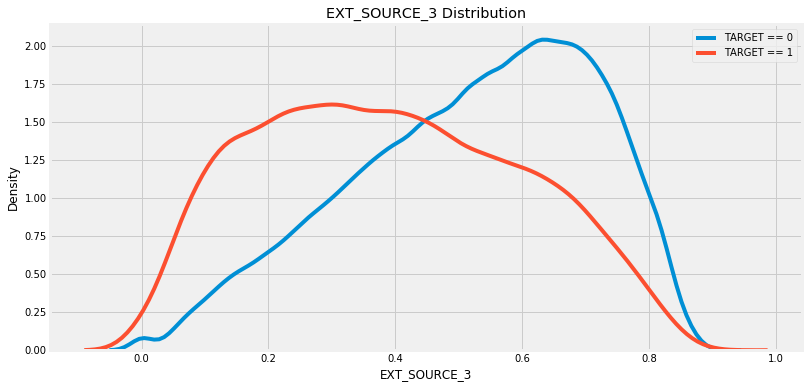

In [13]:
kde_target('EXT_SOURCE_3',train)

The correlation between previous_loan_counts and the TARGET is 0.0041
Median value for loan that was not repaid = 4.0000
Median value for loan that was repaid = 4.0000


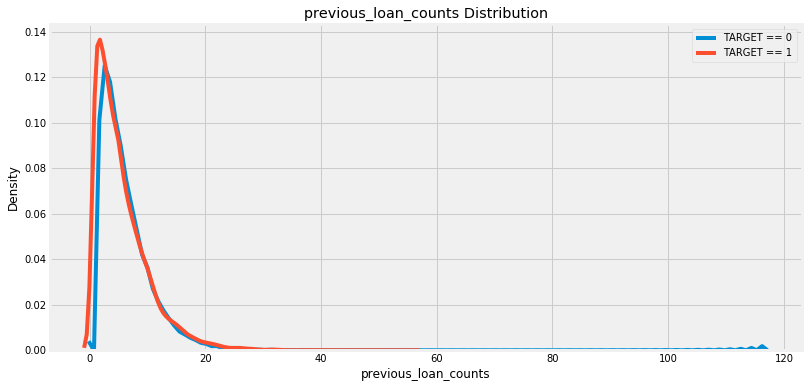

In [14]:
kde_target('previous_loan_counts',train)

In [15]:
# 통계량 계산 
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR',as_index = False).agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [18]:
## 훈련 셋 합치기 
train = train.merge(bureau_agg, on='SK_ID_CURR',how = 'left')
train.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [19]:
## 종속변수에 상관계수 계산 
new_corrs = []

# 종속변수 반복

for col in columns:
    ## 상관계수 계산 
    corr = train['TARGET'].corr(train[col])
    ## 합치기
    new_corrs.append((col,corr))
    
    

In [20]:
## 상관계수 정렬
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]),reverse =True)
new_corrs[:15]


[('bureau_DAYS_CREDIT_mean', 0.08972896721998132),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010391),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968697),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920844),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102095),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758624),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997342),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111618),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835924),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073035),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484685),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.041403635353060284),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632938),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616267),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332554)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


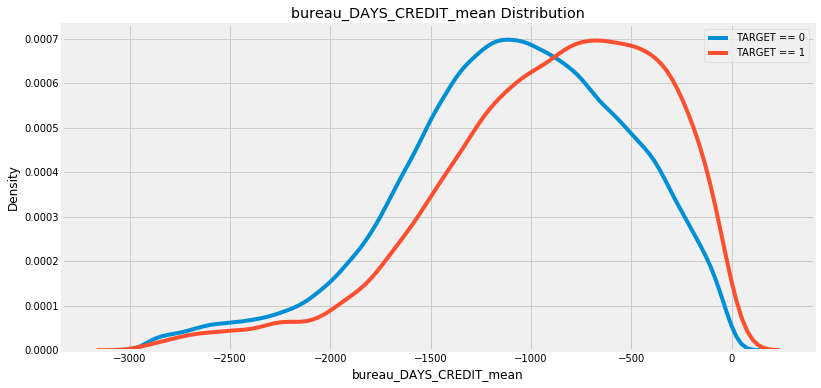

In [21]:
kde_target('bureau_DAYS_CREDIT_mean',train)

수치형 변수에 대한 통계량 산출

In [23]:
def agg_numeric(df,group_var,df_name):
    '''수치형 변수 계산 
    df (dataframe):
            the dataframe to calculate the statistics on 
                        group-var (string):
                                the variable by which to group df 
                                        df_name(string):
                                        '''
    ## id 컬럼 제거 그룹
    
    for col in df:
        if col != group_var and 'SK_ID' in col :
            df = df.drop(columns = col)
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')  ## 특정'타입' 변수만 선택, df.select_dtypes('특정')
    numeric_df[group_var] = group_ids
            
        ## 통계량 계산 및 특정 변수 그룹
            
    agg = numeric_df.groupby(group_var).agg(['count','mean','max','min','sum']).reset_index()
            
        ## 새로운 컬럼 만들기 
            
    columns = [group_var]
        ## 변수명 반복
    for var in agg.columns.levels[0]:
                
            # 그룹핑 변수 건너뛰기
                
        if var != group_var:
                    
                ## 통계 반복
            for stat in agg.columns.levels[1][:-1]:
                        
                    ##새로운 변수 통계량 만들기 
                columns.append('%s_%s_%s' %(df_name, var, stat))
                        
    agg.columns = columns
    return agg


In [24]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']),group_var = 'SK_ID_CURR',df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [25]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


## 상관계수 함수 작성 이유 
- 함수를 작성하여 원하고자 하는 특성에 대해서 각 변수로 파악하기 위해

In [26]:
# 상관계수 함수
def target_corrs(df): 
    ## 빈 리스트 
    corrs = []
    
    #반복 변수명 
    for col in df.columns:
        print(col)
        ## 타켓은 건너뛰기
        
        if col !='TARGET':
            ## 상관계수 계산 
            corr =df['TARGET'].corr(df[col])
            
            #합치기 
            corrs.append((col,corr))
            
            ##정령 
    corrs = sorted(corrs, key = lambda x:abs(x[1]), reverse = True)
    return corrs
        

### 명목형 변수
수치형과 다르게 불연속 문자열로 수치형 변수와 같이 통계량을 산출 할 수 없음, 따라서 각 범주의 수를 계산

### 명목형 변수 함수

In [36]:
## 명목형 변수 다루기 함수 
def count_categorical(df, group_var, df_name):
    ## 명목형 변수 선택
    categorical = pd.get_dummies(df.select_dtypes('object')) ## object == 명목형 변수 
    
    ## 영릐 식별 id 만들기 
    categorical[group_var] = df[group_var]
    
    ## 그룹 및 합/평균 계산 
    categorical = categorical.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    ##반복 수준 0인것     
    for var in categorical.columns.levels[0]:
        ## 반복 통계 수준1
        for stat in ['count','count_norm']:
            ##컬럼 명만들기 
            column_names.append('%s_%s_%s' %(df_name,var,stat))
    categorical.columns = column_names
    return categorical




In [37]:
bureau_counts = count_categorical(bureau,group_var = 'SK_ID_CURR',df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [ ]:
타 금융 기관과의 각 고객의 이전 대출에 대한 월별 정보를 가지고있음


In [38]:
## 다른 데이터 프레임에 적용 
# Read in bureau balance

bureau_balance = pd.read_csv('C:/Users/USER/Desktop/kaggle/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [39]:
## 이전 대출에 대해서 카운트 세기 
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [40]:
# SK _ID_CURR 에 대해서 각 통계량 계산 
bureau_balance_agg =agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU',df_name ='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


## 요약
- 1.각 대출 정보의 수치형 변수를 그룹화 계산
- 2.각 대출 정보의 범주형 변수를 그룹화 계산
- 3.각 통계량 정보와 대출 정보를 병합
- 4.고객 iD기준으로 수치형 변수를 계산 

고객이 존재하면 해당 행에 월별 통계량 정보를 가지고 있음

상관계수 활용


In [41]:
### 이전 데이터 삭제 
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

NameError: name 'bureau_by_loan' is not defined

In [42]:
## 데이터 읽기
train = pd.read_csv('C:/Users/USER/Desktop/kaggle/application_train.csv')
bureau = pd.read_csv('C:/Users/USER/Desktop/kaggle/bureau.csv')
bureau_balance = pd.read_csv('C:/Users/USER/Desktop/kaggle/bureau_balance.csv')

In [ ]:
# 

In [43]:
#이전 대출 이력 횟수 계산
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [44]:
## 통계량 계산 
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [47]:
## 대출에 대한 계좌 계산??
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [49]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [50]:
##고객에 대한 계산 통계량 계산
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU',how = 'outer')
## SK_ID_CURR 기준으로 병합
bureau_by_loan = bureau[['SK_ID_BUREAU','SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')
## 각 고객 통계량 계산 
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'ckient')

In [53]:
## 원본데이터 
original_features = list(train.columns)
print('Original Number of Features:', len(original_features))

Original Number of Features: 122


## train set 특징 

In [54]:
## 범주형 변수 병합
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
## 수치형 변수 병합 
train = train.merge(bureau_agg, on= 'SK_ID_CURR', how = 'left')
## 월별 대출 이력 통계량 Set과병합 
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [55]:
## 원본데이터 컬럼
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data:', len(new_features))

Number of features using previous loans from other institutions data: 333


## 데이터 전처리 

각 변수 결측값 확인 
- 결측값 비율 : 결측값이 비율이 높아 제거할 시, 모델 성능의 향상에 도움이 됨

변수간 상관성 정도 파악 
- 다중공선성 문제 : 변수간 밀접한 관련이 있어 하나의 변수로 볼 수 있는 경우, 하나의 변수 제거 


결측값 처리

In [56]:
# 결측값 계산 함수 
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100*df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis =1)
    
    #컬럼 변경
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # 정렬하기 
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending =False).round(1)
    
    # 요약표 추렭 
    print('Your selected dataframe has' + str(df.shape[1])+'columns.\n'+'There are '+str(mis_val_table_ren_columns.shape[0])+
         'columns that have missing values')
    
    # 결측 정보 
    return mis_val_table_ren_columns
    

In [57]:
# 상위 결측값 비율 10개
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has333columns.
There are 278columns that have missing values


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
ckient_bureau_balance_STATUS_4_count_min,215280,70.0
ckient_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
ckient_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
ckient_bureau_balance_STATUS_4_count_max,215280,70.0
ckient_bureau_balance_STATUS_4_count_mean,215280,70.0
ckient_bureau_balance_STATUS_3_count_norm_min,215280,70.0
ckient_bureau_balance_STATUS_3_count_norm_max,215280,70.0


결측값을 제거하기 위한 명확한 기준이 없으며, 해당 분석가의 판단임

현재는 90%보다 큰 모든 열을 제거함

In [2]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

NameError: name 'missing_train' is not defined

In [ ]:
## 범주형 변수 병합
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
## 수치형 변수 병합 
train = train.merge(bureau_agg, on= 'SK_ID_CURR', how = 'left')
## 월별 대출 이력 통계량 Set과병합 
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

## test set
- 위와 같이 train set 적용한 방법은 test set에 동일하게 적용


In [60]:
## 정보 읽기
test = pd.read_csv('C:/Users/USER/Desktop/kaggle/application_test.csv')

## 범주형 변수 병합
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

## 수치형 변수 병합 
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

## 월별 대출 이력 통계량 Set과병합 
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how= 'left')

print('Shape of Testing Data:', test.shape)


KeyError: 'keft'

train set / test set의 데이터프레임의 열이 일치해야 분석 시 오류를 방지할 수 있음

In [62]:
train_labels =train['TARGET']

train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels
print('Training DATA Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Training DATA Shape: (307511, 287)
Testing Data Shape: (48744, 286)


In [63]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has286columns.
There are 229columns that have missing values


,Missing Values,% of Total Values
COMMONAREA_AVG,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
NONLIVINGAPARTMENTS_MODE,33347,68.4
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2


In [65]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [67]:
missing_columns = list(set(missing_test_vars +missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [68]:
## drop 결측 값 컬럼 
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [5]:
#변수간 상관관계 확인
corrs = train.corr()

In [6]:
##상관성이 높은 변수순으로 정렬 
corrs = corrs.sort_values('TARGET',ascending =False) 
## 상위 10개 변수 확인
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
ckient_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
ckient_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
ckient_bureau_balance_MONTHS_BALANCE_min_min,0.073225
ckient_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927
ckient_bureau_balance_MONTHS_BALANCE_sum_min,0.068072


In [7]:
# 하위 10개 뱐수 확인 
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
FLOORSMIN_AVG,-0.033614
ELEVATORS_MEDI,-0.033863
ELEVATORS_AVG,-0.034199
ckient_bureau_balance_STATUS_0_count_mean,-0.035868
REGION_POPULATION_RELATIVE,-0.037227
AMT_GOODS_PRICE,-0.039645
FLOORSMAX_MODE,-0.043226
FLOORSMAX_MEDI,-0.043768
FLOORSMAX_AVG,-0.044003
ckient_bureau_balance_STATUS_C_count_norm_max,-0.044119


상관성 주의사항
- 변수가 높은 상관관계가 유의미한 변수를 의미하지 않을 수 있으며 수십개의 파생변수와의 관계는 단순 노이즈로 인한 상관계수 일 수 있다. 

- 상관성은 인관관계가 아니다. 
- 3제의 변수로 인하여 상관계수가 높을 있다.

The correlation between ckient_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid = 25.1429


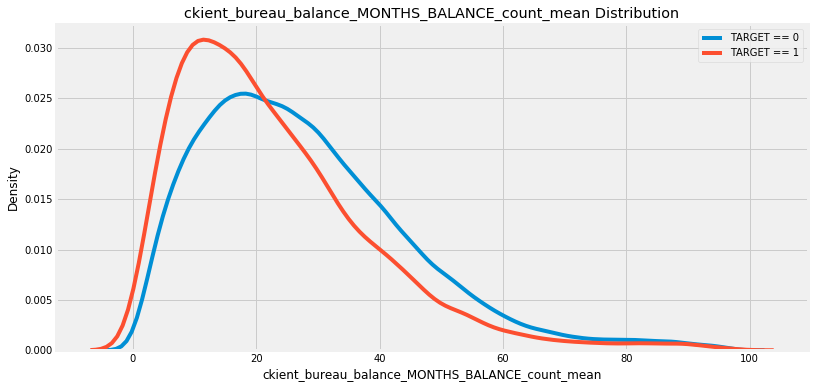

In [11]:
kde_target(var_name = 'ckient_bureau_balance_MONTHS_BALANCE_count_mean', df = train)

In [12]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

KeyError: 'bureau_CREDIT_ACTIVE_Active_count_norm'

'CREDIT_ACTIVE'와 타켓 변수간 상관계수가 작지만 그래프 타켓변수에 따라 그래프 특성이 다름(단순히 변수간 상관계수로 판단해서는 안됨) 

공선변수 : 타켓변수 이외에 독립변수들 간의 상관관계가 높은 변수
- 일반적으로 0.8 이상이면 공선이 있다고 판단되어 제거할 필요성이 있음

In [13]:
# 변수간 공성선 확인 
#동일선상 변수 
threshold = 0.8

# 상관계수 담을 빈 딕셔너리 
above_threshold_vars = {}

# 반복 컬럼

for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

공선성이 있는 변수확인 

In [14]:
# 공성선 있는 변수 중 하나만 제거 
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    
    for x in value:
        if x == key:
            next 
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
                
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove:', len(cols_to_remove))

Number of columns to remove: 125


In [15]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = train.drop(columns = cols_to_remove)

In [16]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv',index =False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv',index =False)

KeyboardInterrupt: 

## Modeling 


- 1. 원본데이터에 대한 학습

- 2. 

In [17]:
#모델링 라이브러리 
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [32]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):  
    # features (train set)랑 test_features(test set) 는 dataframe자체가 들어온다.
    # 위에서 진행한 train_corrs_removed들어 온다.
    
    # '키' 값 추출
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    # 'TARGET' 추출
    labels = features['TARGET']
    #컬럼 제거 
    features = features.drop(columns = ['SK_ID_CURR','TARGET'])
    test_features = test_features.drop(columns =['SK_ID_CURR'])
    # ONE-HOT-ENCODING 
    if encoding =='ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis =1)
        
        cat_indices = 'auto'
    elif encoding =='le':
        label_encoder = LabelEncoder() # 라벨 인코더 생성
        
        cat_indices = []
        #특성만큼 돌면서
        for i , col in enumerate(features):
            #범주형이면 
            if features[col].dtype =='object':
                # 라벨 인코딩
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,))) # fit_transform() : 전환, .astype(str) : 문자로 변환 ,np.array(배열로 만들기) 컬럼은 변환시킴 / 
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,))) # cat_indices.append(i) 범주형 인덱스 넣기
                cat_indices.append(i)
                
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    print('Training Data Shape:', features.shape)
    print('Testing Data Shape:', test_features.shape)
    
    feature_names = list(features.columns)
    
    features = np.array(features)
    test_features = np.array(test_features)
    
    
    k_fold = KFold(n_splits = n_folds, shuffle =False, random_state = 50)   ##교차검증 
    
    feature_importance_values  = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(test_features.shape[0])   ## test 예측 ㄱ밧 
    print('test_predictions shape:', np.shape(test_predictions))
    out_of_fold = np.zeros(features.shape[0])   ##validation 예측 ㄱ밧 
    
    valid_scores = []
    train_scores = []
    #kfold를 돌면서, features 만큼 splite
    for train_indices, valid_indices in k_fold.split(features):
        # k 집합은 나눈 train set
        train_features, train_labels = features[train_indices], labels[train_indices]
        # k 집합은 나눈 validation data 
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        # 모델을 만들고 
        model = lgb.LGBMClassifier(n_estimators = 10, objective ='binary', 
                                  class_weight = 'balanced', learning_rate = 0.05,
                                  reg_alpha = 0.1, reg_lambda = 0.1,
                                  subsample =0.8, n_jobs = -1, random_state =50)
        # 모델 훈련 
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid','train'],categorical_feature =cat_indices,
                  early_stopping_rounds = 100, verbose =200)
        # 최고성적 가져오기
        best_iteration= model.best_iteration_
        # kfold 돌고 모델을 훈련시킴
        feature_importance_values += model.feature_importances_/k_fold.n_splits
        # 에측을 넣어줌 
        test_predictions +=model.predict_proba(test_features, num_iteration = best_iteration)[:,1]/k_fold.n_splits
        
        ## validation 에측 
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:,1]
        
        ## 베스트 스커어 기록
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        ## 메모리 청소
        gc.enable()
        
        del model, train_features, valid_features
        gc.collect()
     
    ## 제출 데이터 프레임
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET':test_predictions})
    
    #특성 중요도를 넣어줌
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance':feature_importance_values})
    
    # valid에 대한 roc_auc_score를 추출
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                           'train': train_scores,
                           'valid': valid_scores})
    
    return submission, feature_importances, metrics


    
    
        
    
                

sklearn.model_selection 에서 KFold 가져오고 
metrics 에서roc_auc_curve    

train,test_ids에 'SK_ID_CURR'각각 넣기 
lebel은 test에 없으니 train에서만 'TARGET'뽑기 불필요한 컬럼은 제거 
ohe로 더미변수 만들기


k_fold = KFold(n_splits = n_folds,shuffe = False, random_state
특성 중요도 그래프 feature_importance_values 를 np.zeros(len(feature_names)) 만큼 생성 
test_predictions = np.zeros(test_features.shape[0]) test를 예측했을 때 넣을 배열 값
out_of fold = np.zeros(features.shape[0]) validation 예측 



In [59]:
def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending =False).reset_index()
    
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    
    
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importance')
    plt.show()
    return df

In [21]:
## Control

train_control = pd.read_csv('C:/Users/USER/Desktop/kaggle/application_train.csv')
test_control = pd.read_csv('C:/Users/USER/Desktop/kaggle/application_test.csv')


original 데이터 훈련

In [33]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape: (307511, 241)
Testing Data Shape: (48744, 241)
test_predictions shape: (48744,)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.734993	train's binary_logloss: 0.643282	valid's auc: 0.728859	valid's binary_logloss: 0.643442
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.734603	train's binary_logloss: 0.64322	valid's auc: 0.726599	valid's binary_logloss: 0.64472
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.736273	train's binary_logloss: 0.642476	valid's auc: 0.719381	valid's binary_logloss: 0.643545
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.734218	train's binary_logloss: 0.643466	valid's auc: 0.729778	valid's binary_logloss: 0.643558
T

In [56]:
metrics

,fold,train,valid
0,0,0.734993,0.728859
1,1,0.734603,0.726599
2,2,0.736273,0.719381
3,3,0.734218,0.729778
4,4,0.734735,0.731310
5,overall,0.734964,0.726976


훈련점수가 유효성 검사점수보다 높기 때문에 정규화가 과정이 필요함


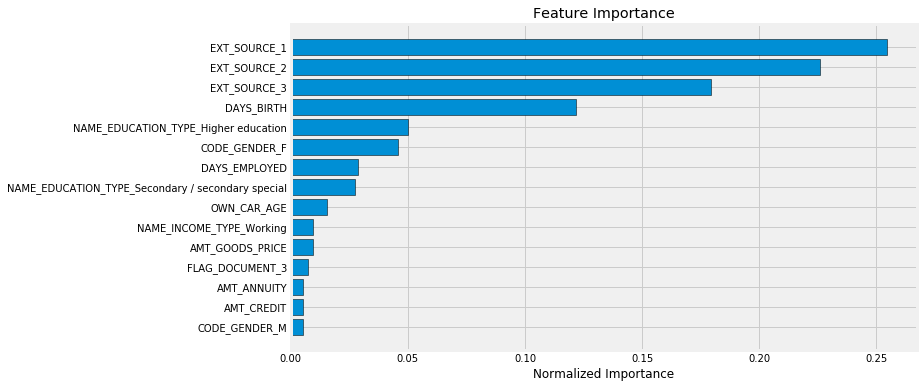

In [60]:
## 변수 중요도를 확인 
fi_sorted = plot_feature_importances(fi)

In [58]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape: (307511, 406)
Testing Data Shape: (48744, 406)
test_predictions shape: (48744,)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.735356	train's binary_logloss: 0.643247	valid's auc: 0.728682	valid's binary_logloss: 0.643487
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.734899	train's binary_logloss: 0.643214	valid's auc: 0.726795	valid's binary_logloss: 0.644657
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.736372	train's binary_logloss: 0.642477	valid's auc: 0.718912	valid's binary_logloss: 0.64359
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.734386	train's binary_logloss: 0.643425	valid's auc: 0.729344	valid's binary_logloss: 0.643577


In [61]:
metrics_raw

,fold,train,valid
0,0,0.735356,0.728682
1,1,0.734899,0.726795
2,2,0.736372,0.718912
3,3,0.734386,0.729344
4,4,0.734867,0.730633
5,overall,0.735176,0.726688


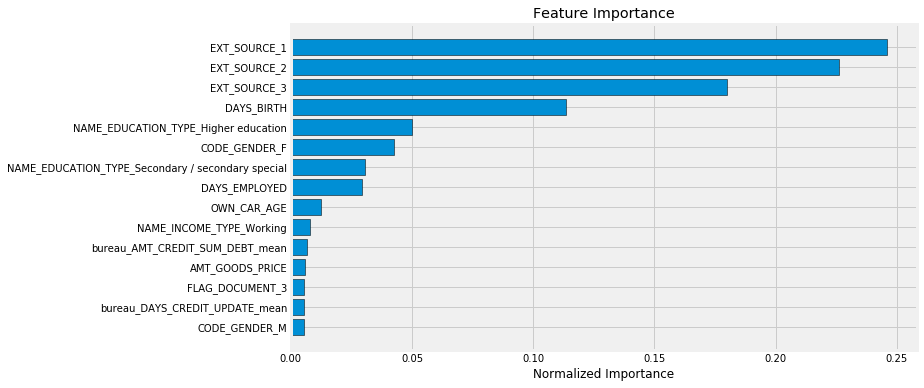

In [62]:
fi_raw_sorted = plot_feature_importances(fi_raw)

In [ ]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]
print('%% of Top 100 Features created from the bureau daa = %d.00' % len(new_features))

In [ ]:
submission_raw.to_csv('test_one.csv',index =False)


Test one scores 0.759

In [63]:
# 공선성있는 변수 제거
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape: (307511, 284)
Testing Data Shape: (307511, 284)
test_predictions shape: (307511,)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.735292	train's binary_logloss: 0.643259	valid's auc: 0.728734	valid's binary_logloss: 0.643474
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.734907	train's binary_logloss: 0.643249	valid's auc: 0.726793	valid's binary_logloss: 0.644721
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.736126	train's binary_logloss: 0.642482	valid's auc: 0.718582	valid's binary_logloss: 0.643571
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's auc: 0.734187	train's binary_logloss: 0.643448	valid's auc: 0.729657	valid's binary_logloss: 0.6435

In [64]:
metrics_corr

,fold,train,valid
0,0,0.735292,0.728734
1,1,0.734907,0.726793
2,2,0.736126,0.718582
3,3,0.734187,0.729657
4,4,0.734773,0.730581
5,overall,0.735057,0.726726


원본데이터 보다 높지만 원시데이터보다 낮다

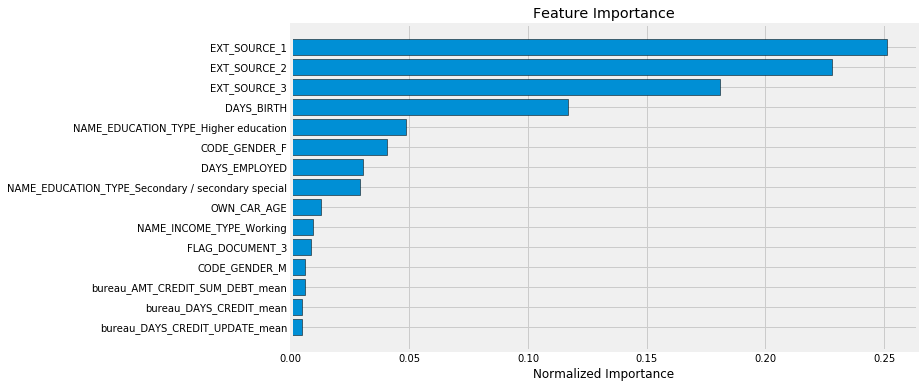

In [65]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

Test two scores 0.753 

In [ ]:
##결과 
추가 정보를 포함 data set이 성능이 가장 높았으며, 

In [1]:
## baggingClassifier
## base_estimator:기본 모형
## n_estimators: 모형 갯수 , 디폴트 10 
## bootstrap:데이터의 중복 사용여부 
## max_samples : 데이터 샘픙 중 선택할 샘플의 수/비율
## bootstrap_features: 특징 차원의 중복여부 
## max_features: 다차원 독립 변수 중 선택할 차원의 수 

In [ ]:
RandomForestClassifier
AdaBoostClassifier
https://datascienceschool.net/view-notebook/7d82087c31d64fe491dc74e1d5953ca2/
GradientBoostingClassifier
ExtraTreesClassifier

https://excelsior-cjh.tistory.com/166
 GridSearchCV # 하이퍼 파라미터 최적화 

grid_scores_
param_grid 의 모든 파리미터 조합에 대한 성능 결과. 각각의 원소는 다음 요소로 이루어진 튜플이다.
parameters: 사용된 파라미터
mean_validation_score: 교차 검증(cross-validation) 결과의 평균값
cv_validation_scores: 모든 교차 검증(cross-validation) 결과
best_score_
최고 점수
best_params_
최고 점수를 낸 파라미터
best_estimator_
최고 점수를 낸 파라미터를 가진 모형
n_jobs = 병렬처리 
교차검증 -cross_val_score
K -폴드 교차검증 
https://datascienceschool.net/view-notebook/266d699d748847b3a3aa7b9805b846ae/

위와 같이 교차검증을 반복하는 코드를 더 간단하게 만들어주는 함수가 있다. 바로 cross_val_score이다. 사용법은 다음과 같다.

cross_val_score(model, X, y, scoring=None, cv=None)
model : 회귀 분석 모형
X : 독립 변수 데이터
y : 종속 변수 데이터
scoring : 성능 검증에 사용할 함수 이름
cv : 교차검증 생성기 객체 또는 숫자.
None이면 KFold(3)
숫자 k이면 KFold(k)
learning_curve # 학습곡선 함수 
https://datascienceschool.net/view-notebook/f750964a004549709c4465af3d0cf04f/


StratifiedKFold
//https://homeproject.tistory.com/m/6


DecisionTreeClassifier
https://datascienceschool.net/view-notebook/16c28c8c192147bfb3d4059474209e0a/





In [ ]:

GridSearchCV( model,       # estimator
            param_grid=,   # 찾고자하는 파라미터. dict형식
            cv= 2 or KFold(2),
            scoring=None,  #  Classification일때  'accuracy','f1'
                           #  Regression 일때 'neg_mean_squared_error','r2'...
                           # 자세한건 아래 링크를 통해 확인 가능합니다.
            n_jobs= 4,     # 병렬 처리갯수? -1은 전부)
            refit=True     # default가 True. 
                           # 좋은 estimator로 수정되어짐.
            )   


GCV=GridSErchCV( )         # 옵션.
GCV.fit( )                 # train_X, train_Y 
GCV.best_params_           # 좋은 파라미터를 보여줌.
GCV.best_score_            # 0.88 좋은 estimator로
                           # 교차검증된점수를 보여줌.

 예측방법.1
 
model=GCV.best_estimator_  # 최적의 파라미터로 모델 생성
model.predict()            # refit=True이기때문에 좋은 estimator로
                           # 수정되어졌으므로 바로 예측에 적용할 수 있다.
 예측방법2
GCV.predict( )             # test_X,  학습후 최적의 파라미터로 예측한다.


모델링 과정 
--> 1.각 모델 적용 및 교차검증 시작 (여러가지 모형 적용)
모형 선택 
--> 2.각 모델 하이퍼튜닝 best 모델 (선택된 모형 최적)

--> 3. 각 모형 train valida 비교 learning 비교 
--> 4. 변수 중요도

--> 4.
